In [1]:
from src.reachability_analysis.simulation import get_test_label, run_scenario, get_data, get_initial_conditions
from src.clustering.run import load_config, get_cluster
from src.reachability_analysis.labeling_oracle import LABELS, LabelingOracleSINDData
from src.reachability_analysis.utils import load_data
import matplotlib.pyplot as plt
from PIL import Image
import os


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization m

In [2]:
ROOT = os.getcwd()
ROOT_RESOURCES = os.getcwd() + '/resources'

In [3]:
REVERSED_LABELS = {value: key for key, value in LABELS.items()}

In [4]:
model_file = 'SINDDataset_pretrained_2024-04-27_00-11-45_KIP'

index = 2
index_data = 0
folder = 'experiments'

### Zonotopes

In [5]:
ROOT_RESOURCES = ROOT + '/resources'
config = load_config(folder=folder, model_file=model_file, index=index, index_data=index_data)

In [6]:

REVERSED_LABELS

{0: 'cross_left',
 1: 'cross_right',
 2: 'cross_straight',
 3: 'cross_illegal',
 4: 'crossing_now',
 5: 'not_cross',
 6: 'unknown'}

2024-07-30 13:50:50,908 | INFO : Loading 1 datasets files using 1 parallel processes ...
Labeling data: 100%|██████████| 1/1 [00:00<00:00, 2700.78it/s]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-30 13:50:50,964 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, b

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.139438
Trajectory data shape need to be of shape  (n, m). Get 4 dimension as past trajectory
Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/annoy_index.ann
Trajectory data shape need to be of shape  (n, m). Get 4 dimension as past trajectory
Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/original_annoy_index.ann
Name:

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


X_p.size 490 (2, 245)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 174.13it/s]


X_p.size 1078 (2, 539)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 74.79it/s]


Area of zonotope:  122.0815  m^2
Area of (baseline) zonotope:  657.0511  m^2
X_p.size 8624 (2, 4312)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}, 'T-b Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:04<00:00, 11.09it/s]


Area of zonotope:  73.8813  m^2
X_p.size 686 (2, 343)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}, 'T-b Cluster': {'memory_constraint': 0, 'data_constraint': 0}, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 140.25it/s]


Area of zonotope:  204.1029  m^2


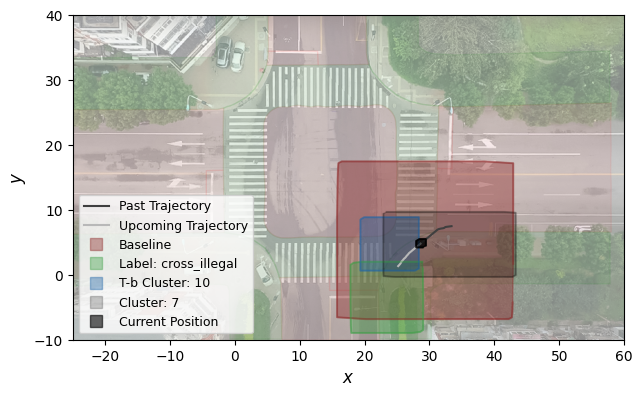

2024-07-30 13:50:59,352 | INFO : Loading 1 datasets files using 1 parallel processes ...
Labeling data: 100%|██████████| 1/1 [00:00<00:00, 1506.03it/s]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-30 13:50:59,413 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, b

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.0567846
Trajectory data shape need to be of shape  (n, m). Get 26 dimension as past trajectory
Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/annoy_index.ann
Trajectory data shape need to be of shape  (n, m). Get 26 dimension as past trajectory
Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/original_annoy_index.ann
Na

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


X_p.size 490 (2, 245)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 158.44it/s]


X_p.size 5684 (2, 2842)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:03<00:00, 15.83it/s]


Area of zonotope:  141.6194  m^2
Area of (baseline) zonotope:  396.1144  m^2
X_p.size 5390 (2, 2695)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}, 'T-b Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:03<00:00, 15.96it/s]


Area of zonotope:  52.6826  m^2
X_p.size 1960 (2, 980)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}, 'T-b Cluster': {'memory_constraint': 0, 'data_constraint': 0}, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:01<00:00, 43.59it/s]


Area of zonotope:  169.2804  m^2


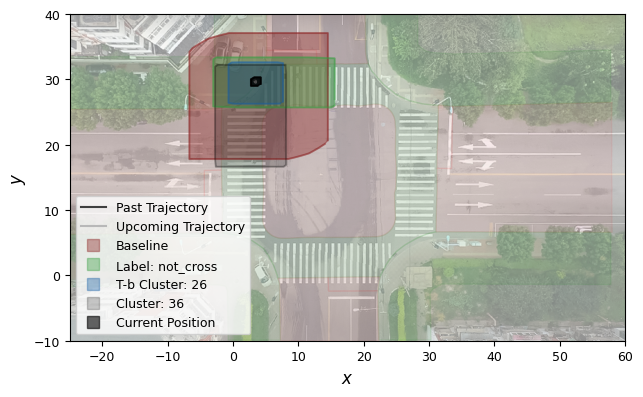

2024-07-30 13:51:09,518 | INFO : Loading 1 datasets files using 1 parallel processes ...
Labeling data: 100%|██████████| 1/1 [00:00<00:00, 1818.08it/s]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-30 13:51:09,586 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, b

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.111576
Trajectory data shape need to be of shape  (n, m). Get 3 dimension as past trajectory
Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/annoy_index.ann
Trajectory data shape need to be of shape  (n, m). Get 3 dimension as past trajectory
Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/original_annoy_index.ann
Name:

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


X_p.size 9408 (2, 4704)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:05<00:00,  9.37it/s]


X_p.size 5684 (2, 2842)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:03<00:00, 15.46it/s]


Area of zonotope:  98.4315  m^2
Area of (baseline) zonotope:  454.6648  m^2
X_p.size 1862 (2, 931)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}, 'T-b Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:01<00:00, 47.39it/s]


Area of zonotope:  172.4226  m^2
X_p.size 1666 (2, 833)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Label': {'memory_constraint': 0, 'data_constraint': 0}, 'T-b Cluster': {'memory_constraint': 0, 'data_constraint': 0}, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 54.83it/s]


Area of zonotope:  155.7381  m^2


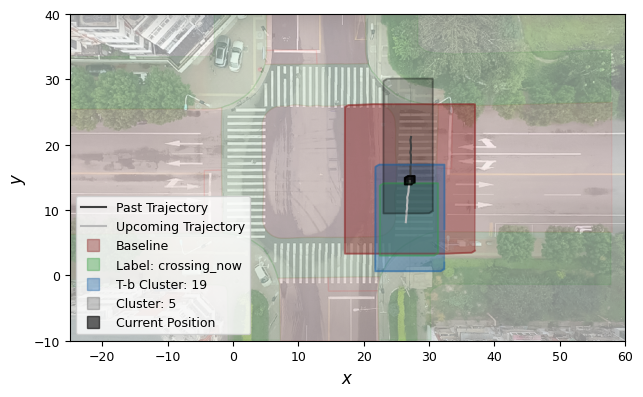

In [7]:
TEST_TRAJECTORIES = {
    'cross_illegal': 4,
    'not_cross': 26,
    'crossing_now': 3,
}
for test_name, chunk in TEST_TRAJECTORIES.items():
    config_test = config.copy()
    config_test['data_dir'] = ROOT_RESOURCES + f'/test/{test_name}'
    test_labeling_oracle = LabelingOracleSINDData(config_test)
    test_labeling_oracle.load_data()
    test_labeling_oracle.config['original_data'] = False

    trajectory, l = get_test_label(test_labeling_oracle, chunk=chunk)
    c, distance_c = get_cluster(config, test_labeling_oracle, chunk=chunk)

    test_labeling_oracle.config['original_data'] = True
    co, distance_co = get_cluster(config, test_labeling_oracle, chunk=chunk)

    if distance_co > 3 or distance_c > 3:
        print("No cluster found that is close enough")
        continue
    test_cases = {f'l_{l}': f'Label: {REVERSED_LABELS[l]}', f'c_{c}': f'T-b Cluster: {c}',  f'co_{co}': f'Cluster: {co}'}

    print(f"Name: {test_name},", test_cases)
    run_scenario(trajectory=trajectory, config=config, labels=test_cases, show_path=True, baseline=True, show_plot=True, save_plot=config_test['data_dir'])

2024-07-30 14:07:31,397 | INFO : Loading 1 datasets files using 1 parallel processes ...
Labeling data: 100%|██████████| 1/1 [00:00<00:00, 1731.75it/s]
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-07-30 14:07:31,452 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, b

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.144347
Trajectory data shape need to be of shape  (n, m). Get 4 dimension as past trajectory
Load data from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters
Load Annoy Model from: /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/eval/clusters/annoy_index.ann
Name: cross_illegal, {'c_10': 'T-b Cluster: 10'}


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


X_p.size 8624 (2, 4312)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'T-b Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:04<00:00, 10.00it/s]


Area of zonotope:  73.8813  m^2


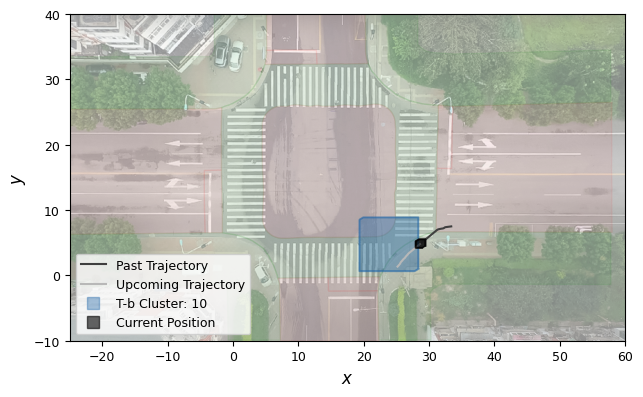

In [20]:
test_name = list(TEST_TRAJECTORIES.keys())[0]
chunk = TEST_TRAJECTORIES[test_name]

config_test = config.copy()
config_test['data_dir'] = ROOT_RESOURCES + f'/test/{test_name}'
test_labeling_oracle = LabelingOracleSINDData(config_test)
test_labeling_oracle.load_data()

trajectory, _ = get_test_label(test_labeling_oracle, chunk=chunk)
c, distance_c = get_cluster(config, test_labeling_oracle, chunk=chunk)

if distance_co > 3 or distance_c > 3:
    print("No cluster found that is close enough")

test_cases = {f'c_{c}': f'T-b Cluster: {c}'}

print(f"Name: {test_name},", test_cases)
run_scenario(trajectory=trajectory, config=config, labels=test_cases, show_path=True, baseline=False, show_plot=True)

Combine Final Images for Paper

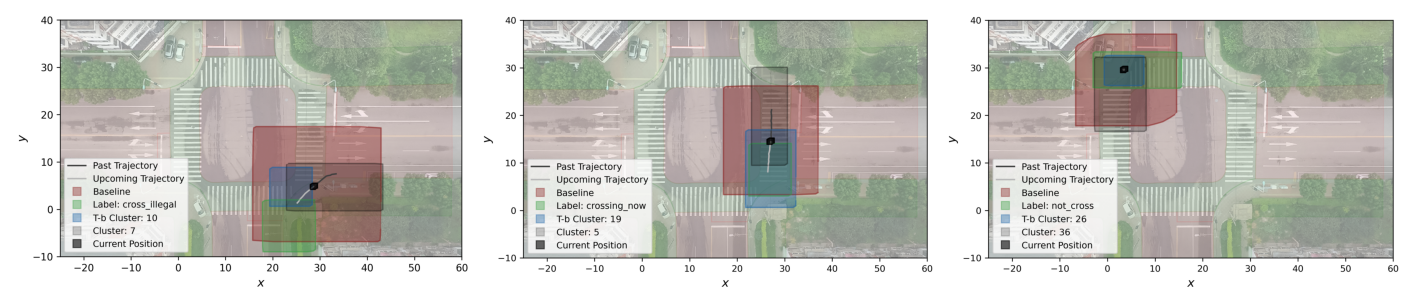

In [13]:
def combine_images(image_paths, output_path):
    # Determine the number of images
    num_images = len(image_paths)
    
    # Create a matplotlib figure with multiple subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 6, 5))
    
    # Check if there's only one subplot (axes could be an AxesSubplot object, not an array)
    if num_images == 1:
        axes = [axes]
    
    # Loop through the images and their respective axes
    for ax, img_path in zip(axes, image_paths):
        # Open the image file
        with Image.open(img_path) as img:
            # Convert the image file to an array
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust spacing between images if needed
    plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Example usage
test_names = list(TEST_TRAJECTORIES.keys())
image_paths = [
    ROOT_RESOURCES + f'/test/{test_names[0]}/use.png',
    ROOT_RESOURCES + f'/test/{test_names[2]}/use.png',
    ROOT_RESOURCES + f'/test/{test_names[1]}/use.png',
]
output_path = ROOT_RESOURCES + '/test/combined_image.jpg'
combine_images(image_paths, output_path)

### Clsuter picked for Zonotope

In [ ]:
c , l

In [ ]:
_sind_, d, _, mapping = get_data(_load=True, config=config, test_case=(c, 'Cluster'))
_mode = mapping[c]
_mode

In [ ]:
len(d[_mode])

In [ ]:
_sind_.map.plot_dataset(pedestrian_data={i: data for i, data in enumerate(d[_mode])}, color='red', title=f'cluster_{c}', alpha_trajectories=0.3)